# Doublet Detection

### Setup and Load Data

DoubletDetection expects counts to be in the cellranger output format either as h5 file (filtered_feature_bc_matrix.h5) or matrix directory (directory containing `barcodes.tsv`, `genes.tsv` and `matrix.mtx` or `barcodes.tsv.gz`, `features.tsv.gz` and `matrix.mtx.gz`)

If you don’t have your data in either of these formats, you can run DoubletDetection manually in python and load the data in using a method of your choosing.

In [11]:
import os
import numpy as np
import doubletdetection
import tarfile
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import sys
import pandas as pd
import scanpy as sc
import scipy
import scipy.io

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# data files are in the filtered matrix folder from CellRanger which has been renamed to the sample name
sample_name = r'sc92_1_filtered' #r'sc70_1' #r'sc72_1'
data_path = r"../raw_data/"
data_files_path = data_path + sample_name + r""

results_path = 'results/'
results_file = results_path + sample_name + 'dblDetect-db.h5ad'  # the file that will store the analysis results
metrics_file = results_path + sample_name + 'dblDetect_db_metrics.csv'  # the file that will store the metrics
# make results folder if it doesn't exist
if not os.path.exists(results_path):
    os.makedirs(results_path, exist_ok=False)

scanpy==1.10.4 anndata==0.11.1 umap==0.5.7 numpy==2.0.2 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.6.0 statsmodels==0.14.4 igraph==0.11.8 louvain==0.8.2 pynndescent==0.5.13


In [12]:
adata = sc.read_10x_mtx(
    data_files_path,              # the directory with the `.mtx` file
    var_names='gene_symbols',     # use gene symbols for the variable names (variables-axis index)
    cache=True)                   # write a cache file for faster subsequent reading

# adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
print('Data matrix is sparse:', scipy.sparse.issparse(adata.X))
print()

# make the obs names unique by adding the sample name
adata.obs_names = [g.split("-")[0] + '_' + sample_name for g in adata.obs_names]
print(adata.obs_names[0:2])
print()
print('Number of cells =', f"{adata.n_obs:,.0f}")
print('Number of genes =', f"{adata.n_vars:,.0f}")
print('Number of counts =', f"{adata.X.sum():,.0f}")
print('Mean counts per cell =', f"{adata.X.sum()/adata.n_obs:,.0f}")
adata

... reading from cache file cache/..-raw_data-sc92_1_filtered-matrix.h5ad
Data matrix is sparse: True

Index(['AAACCTGAGAAACGAG_sc92_1_filtered', 'AAACCTGAGACTTGAA_sc92_1_filtered'], dtype='object')

Number of cells = 13,911
Number of genes = 32,285
Number of counts = 66,679,024
Mean counts per cell = 4,793


AnnData object with n_obs × n_vars = 13911 × 32285
    var: 'gene_ids', 'feature_types'

In [13]:
n_cells = adata.n_obs
n_genes = adata.n_vars
n_counts = adata.X.sum()    
counts_per_cell = round(n_counts / n_cells)

df_metrics = pd.DataFrame({"Number of cells": [n_cells],
                          "Number of genes": [n_genes], 
                          "Number of counts": [n_counts], 
                          "Mean counts per cell": [counts_per_cell]}, 
                          index=[sample_name])


df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].map('{:,.0f}'.format)
df_metrics.index = [sample_name]
df_metrics

/var/folders/v8/ptd2qrdj11bf42tp5y0_42700000gn/T/ipykernel_69457/1653201150.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sc92_1_filtered    32,285
Name: Number of genes, dtype: object' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].map('{:,.0f}'.format)
/var/folders/v8/ptd2qrdj11bf42tp5y0_42700000gn/T/ipykernel_69457/1653201150.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sc92_1_filtered    66,679,024
Name: Number of counts, dtype: object' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].map('{:,.0f}'.format)
/var/folders/v8/ptd2qrdj11bf42tp5y0_42700000gn/T/ipykernel_69457/1653201150.py:13: FutureWarning: Setting an item of incompatible dtype is deprecat

,Number of cells,Number of genes,Number of counts,Mean counts per cell
sc92_1_filtered,13911,"32,285","66,679,024","4,793"


### Detect doublets
Remove "empty" genes before doublet detection.

In [14]:
sc.pp.filter_genes(adata, min_cells=1)
df_metrics['Filter genes:'] = ' '
df_metrics['Number of genes removed'] = n_genes - adata.n_vars

filtered out 6596 genes that are detected in less than 1 cells


In [15]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:01)


In [16]:
# IMPORTANT: changed `np.log(scaled_aug_counts.A + 0.1)` => `np.log(scaled_aug_counts.toarray() + 0.1)` in DoubletDetection source code
svd_solver='arpack'

clf = doubletdetection.BoostClassifier(
    n_iters=10,
    clustering_algorithm="leiden",
    standard_scaling=True,
    pseudocount=0.1,
    n_jobs=-1,
)
doublets = clf.fit(adata.X).predict(p_thresh=1e-16, voter_thresh=0.5)
doublet_score = clf.doublet_score()

/Users/christinesong/Downloads/School/BIO446/McKinnonRosatiLab/Project2/jl/lib/python3.12/site-packages/doubletdetection/doubletdetection/doubletdetection.py:116: UserWarning: Leiden clustering is experimental and results have not been validated.
  warnings.warn("Leiden clustering is experimental and results have not been validated.")
/Users/christinesong/Downloads/School/BIO446/McKinnonRosatiLab/Project2/jl/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    with n_comps=30
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 84 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:03)
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    with n_comps=30
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['con

### Results
Doublet vs singlet ratios

In [17]:
adata.obs["doublet"] = doublets
adata.obs["dblDetect_score"] = doublet_score
adata.obs["dblDetect_class"] = ['doublet' if x == 1.0 else 'singlet' for x in doublets]

adata.obs

,doublet,dblDetect_score,dblDetect_class
AAACCTGAGAAACGAG_sc92_1_filtered,0.0,7.083729e-01,singlet
AAACCTGAGACTTGAA_sc92_1_filtered,0.0,2.224186e-03,singlet
AAACCTGAGCAGATCG_sc92_1_filtered,0.0,5.375477e-28,singlet
AAACCTGAGGACAGAA_sc92_1_filtered,0.0,1.782626e-01,singlet
AAACCTGAGGACAGCT_sc92_1_filtered,0.0,1.231407e-01,singlet
...,...,...,...
TTTGTCATCATCGATG_sc92_1_filtered,0.0,6.200994e-01,singlet
TTTGTCATCGCAGGCT_sc92_1_filtered,0.0,4.537068e-15,singlet
TTTGTCATCGGTCCGA_sc92_1_filtered,0.0,6.200994e-01,singlet
TTTGTCATCTAACTGG_sc92_1_filtered,0.0,3.874671e-01,singlet


In [18]:
adata.obs["doublet"] = doublets
adata.obs["dblDetect_score"] = doublet_score
adata.obs["dblDetect_class"] = ['doublet' if x == 1.0 else 'singlet' for x in doublets]

adata.obs

,doublet,dblDetect_score,dblDetect_class
AAACCTGAGAAACGAG_sc92_1_filtered,0.0,7.083729e-01,singlet
AAACCTGAGACTTGAA_sc92_1_filtered,0.0,2.224186e-03,singlet
AAACCTGAGCAGATCG_sc92_1_filtered,0.0,5.375477e-28,singlet
AAACCTGAGGACAGAA_sc92_1_filtered,0.0,1.782626e-01,singlet
AAACCTGAGGACAGCT_sc92_1_filtered,0.0,1.231407e-01,singlet
...,...,...,...
TTTGTCATCATCGATG_sc92_1_filtered,0.0,6.200994e-01,singlet
TTTGTCATCGCAGGCT_sc92_1_filtered,0.0,4.537068e-15,singlet
TTTGTCATCGGTCCGA_sc92_1_filtered,0.0,6.200994e-01,singlet
TTTGTCATCTAACTGG_sc92_1_filtered,0.0,3.874671e-01,singlet


In [19]:
doublet_percentage = sum(doublets)/adata.n_obs*100
print('Doublet percentage = %4.1f' %(doublet_percentage))
df_metrics['Doublet removal:'] = ' '
df_metrics['Doublet percentage'] =  doublet_percentage
# print(adata.obs)
adata.obs.dblDetect_class.value_counts() 

Doublet percentage =  4.1


dblDetect_class
singlet    13341
doublet      570
Name: count, dtype: int64

In [25]:
num_before = adata.n_obs
singlets = adata.obs["dblDetect_class"] == 'singlet'
num_after = adata[singlets].n_obs
n_genes = adata[singlets].n_vars
n_counts = adata[singlets].X.sum()    
counts_per_cell = round(n_counts / n_cells)

print('Number of cells before doublet removal =', num_before)
print('Number of cells after doublet removal =', num_after)
print('Number of cells removed =', num_before - num_after)
removed_percentage = (num_before - num_after)/num_before*100
print('Percentage of cells removed = %4.1f' %(removed_percentage))
n_counts = adata.X.sum()  
print('Number of counts =', f"{n_counts:,.0f}")
print('Mean counts per cell =', f"{counts_per_cell:,.0f}")

df_metrics['Number of cells removed'] =  num_before - num_after
df_metrics['After doublet removal:'] = ' '
df_metrics['Number of cells -db'] = num_after
df_metrics['Number of genes -db'] = n_genes
df_metrics['Number of counts -db'] = n_counts
df_metrics['Mean counts per cell -db'] = counts_per_cell

Number of cells before doublet removal = 13911
Number of cells after doublet removal = 13341
Number of cells removed = 570
Percentage of cells removed =  4.1
Number of counts = 20,341,328
Mean counts per cell = 1,387


### Visuals
Visualizing the data after doublet removal through violin plots, UMAPs, and scatterplots

In [26]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:04)


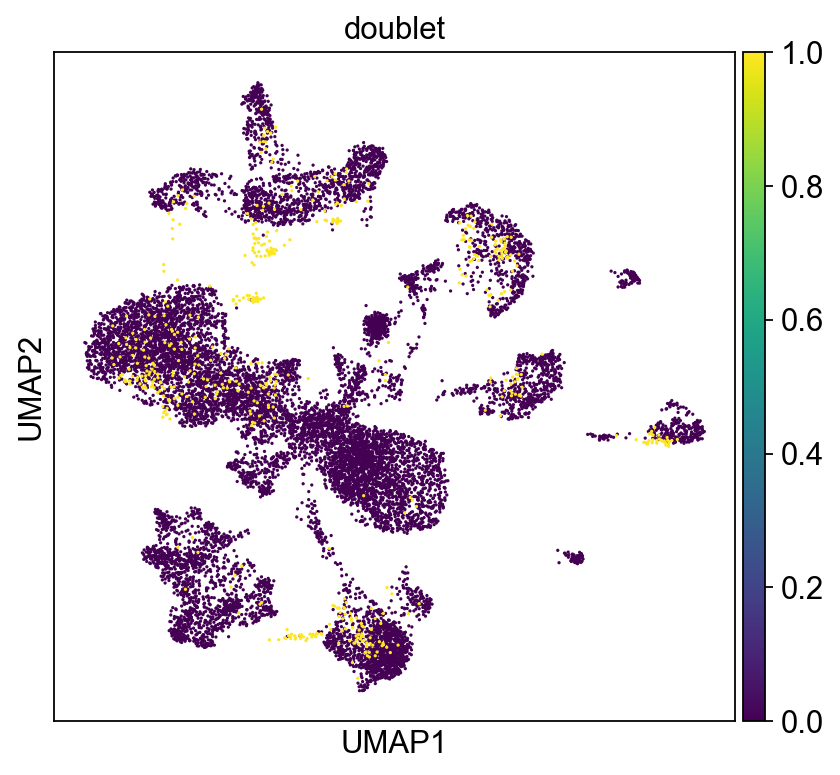

In [27]:
rcParams['figure.figsize'] = 6, 5.5
sc.pl.umap(adata, color='doublet', legend_loc='best')

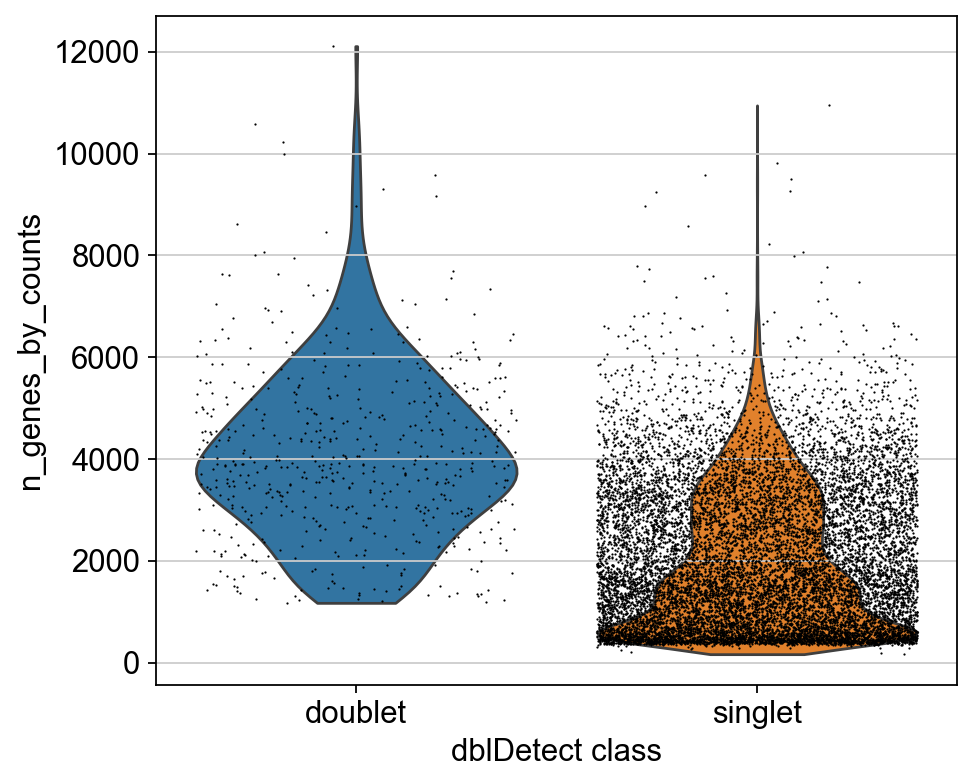

In [28]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby = 'dblDetect_class')

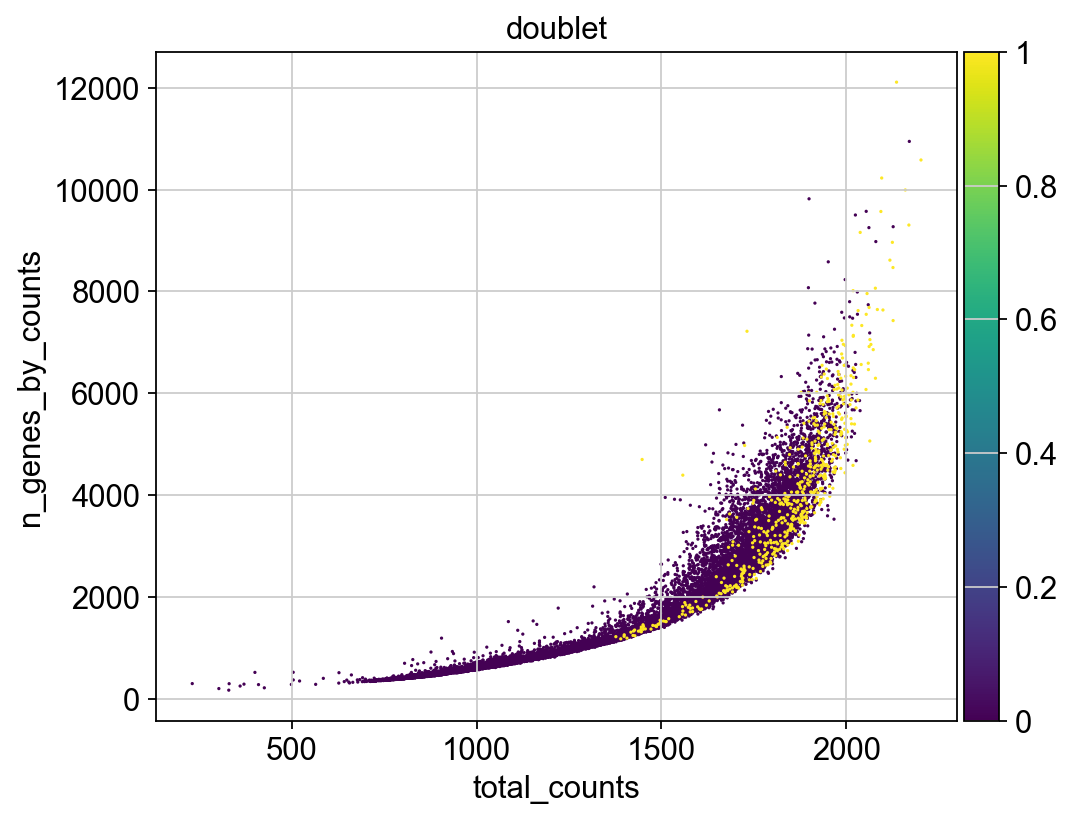

In [29]:
sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='doublet')

### Exporting Doublets to a `.txt` file
Printing out doublet subsets for future comparisons

In [30]:
print(adata.obs[adata.obs['dblDetect_class'] == 'doublet'])
adata_dbl = adata[adata.obs['dblDetect_class'] == 'doublet'].copy()

                                  doublet  dblDetect_score dblDetect_class  \
AAACGGGAGCCGGTAA_sc92_1_filtered      1.0       178.630977         doublet   
AAACGGGCATGACGGA_sc92_1_filtered      1.0       139.306162         doublet   
AAAGATGAGTTACGGG_sc92_1_filtered      1.0       164.100269         doublet   
AAAGATGGTCGAATCT_sc92_1_filtered      1.0       163.047193         doublet   
AAAGTAGAGCTGTCTA_sc92_1_filtered      1.0        44.921713         doublet   
...                                   ...              ...             ...   
TTTACTGGTGCATCTA_sc92_1_filtered      1.0        52.141203         doublet   
TTTCCTCAGGCATTGG_sc92_1_filtered      1.0       178.630977         doublet   
TTTCCTCGTTGATTCG_sc92_1_filtered      1.0        54.406532         doublet   
TTTGTCAGTTCGCGAC_sc92_1_filtered      1.0       178.630977         doublet   
TTTGTCATCAGTCAGT_sc92_1_filtered      1.0        44.901466         doublet   

                                  n_genes_by_counts  total_coun

In [31]:
print(adata_dbl.obs_names)

Index(['AAACGGGAGCCGGTAA_sc92_1_filtered', 'AAACGGGCATGACGGA_sc92_1_filtered',
       'AAAGATGAGTTACGGG_sc92_1_filtered', 'AAAGATGGTCGAATCT_sc92_1_filtered',
       'AAAGTAGAGCTGTCTA_sc92_1_filtered', 'AAAGTAGGTACCTACA_sc92_1_filtered',
       'AAATGCCGTGTGACCC_sc92_1_filtered', 'AACACGTAGTGTCTCA_sc92_1_filtered',
       'AACACGTCAAGCCTAT_sc92_1_filtered', 'AACCATGGTTCAGGCC_sc92_1_filtered',
       ...
       'TTGCGTCCAGTCAGAG_sc92_1_filtered', 'TTGGAACAGGCGCTCT_sc92_1_filtered',
       'TTGGAACTCTACCTGC_sc92_1_filtered', 'TTGTAGGCATTGGTAC_sc92_1_filtered',
       'TTTACTGGTCCAGTTA_sc92_1_filtered', 'TTTACTGGTGCATCTA_sc92_1_filtered',
       'TTTCCTCAGGCATTGG_sc92_1_filtered', 'TTTCCTCGTTGATTCG_sc92_1_filtered',
       'TTTGTCAGTTCGCGAC_sc92_1_filtered', 'TTTGTCATCAGTCAGT_sc92_1_filtered'],
      dtype='object', length=570)


In [33]:
with open("./results/DblDetect_sc92_1_leiden_ids.txt", "w") as txt_file:
    for cell in adata_dbl.obs_names:
        txt_file.write(cell + "\n")